In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import random


# Load data
url = "https://raw.githubusercontent.com/desstaw/PrivacyPreservingTechniques/main/datasets/adult.csv"
df = pd.read_csv(url)

import warnings
warnings.simplefilter('ignore')

In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.3 MB/s eta 0:00:00


### Split column names

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 1 columns):
 #   Column                                                                                     Non-Null Count  Dtype 
---  ------                                                                                     --------------  ----- 
 0   ID;sex;age;race;marital-status;education;native-country;workclass;occupation;salary-class  30162 non-null  object
dtypes: object(1)
memory usage: 235.8+ KB


In [ ]:

df[['ID', 'sex', 'age', 'race', 'marital-status', 'education', 'native-country', 'workclass', 'occupation', 'salary-class']] = df['ID;sex;age;race;marital-status;education;native-country;workclass;occupation;salary-class'].str.split(';', expand=True)

df.drop(df.columns[0], axis=1, inplace=True)


## Baseline Classification accuracy results for the raw dataset

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score, classification_report


features = ['sex', 'salary-class', 'age', 'education', 'occupation', 'marital-status', 'workclass', 'native-country', 'race']



featurez_matrix = df[features]


# Prepare the feature matrix (X) and target variable (y)
X = featurez_matrix.drop('salary-class', axis=1)
y = featurez_matrix['salary-class']


# Convert categorical features to strings
categorical_features_indices = X.select_dtypes(include=['object']).columns
#X[categorical_features_indices] = X[categorical_features_indices].astype(str)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



# Initialize the CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=500, depth=8, learning_rate=0.1, loss_function='Logloss', cat_features=list(categorical_features_indices))

# Train the model on the training data
catboost_model.fit(X_train, y_train, cat_features=list(categorical_features_indices))  # Convert to list here

# Predict on the testing data
y_pred = catboost_model.predict(X_test)
# Convert the predicted labels to string type
y_pred = y_pred.astype(str)


# Evaluate the model's performance
classification_metrics = classification_report(y_test, y_pred)
print(classification_metrics)


# Convert labels to binary values (0 and 1)
y_test_binary = np.where(y_test == '<=50K', 0, 1)
y_pred_binary = np.where(y_pred == '<=50K', 0, 1)

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(y_test_binary, y_pred_binary)
print("AUC-ROC Score:", auc_roc)

0:	learn: 0.6129188	total: 196ms	remaining: 1m 37s
1:	learn: 0.5548684	total: 277ms	remaining: 1m 8s
2:	learn: 0.5117155	total: 344ms	remaining: 56.9s
3:	learn: 0.4797333	total: 389ms	remaining: 48.3s
4:	learn: 0.4515950	total: 455ms	remaining: 45.1s
5:	learn: 0.4327654	total: 495ms	remaining: 40.7s
6:	learn: 0.4165015	total: 543ms	remaining: 38.2s
7:	learn: 0.4052540	total: 595ms	remaining: 36.6s
8:	learn: 0.3962931	total: 642ms	remaining: 35s
9:	learn: 0.3882930	total: 710ms	remaining: 34.8s
10:	learn: 0.3820259	total: 761ms	remaining: 33.8s
11:	learn: 0.3771868	total: 812ms	remaining: 33s
12:	learn: 0.3726888	total: 865ms	remaining: 32.4s
13:	learn: 0.3695502	total: 924ms	remaining: 32.1s
14:	learn: 0.3667908	total: 981ms	remaining: 31.7s
15:	learn: 0.3643349	total: 1.03s	remaining: 31.2s
16:	learn: 0.3633277	total: 1.06s	remaining: 30.1s
17:	learn: 0.3615469	total: 1.11s	remaining: 29.8s
18:	learn: 0.3600632	total: 1.18s	remaining: 30s
19:	learn: 0.3585126	total: 1.24s	remaining: 2

## Generalization

An insight into the unique categorical values and their distribution balance

In [ ]:
columns_to_analyze = ['sex', 'race', 'marital-status', 'education', 'native-country', 'workclass', 'occupation', 'salary-class', 'age']

for column in columns_to_analyze:
    unique_classes_counts = df[column].value_counts()
    print(f"Column: {column}")
    print(unique_classes_counts)
    print("\n")

Column: sex
Male      20380
Female     9782
Name: sex, dtype: int64


Column: race
White                 25933
Black                  2817
Asian-Pac-Islander      895
Amer-Indian-Eskimo      286
Other                   231
Name: race, dtype: int64


Column: marital-status
Married-civ-spouse       14065
Never-married             9726
Divorced                  4214
Separated                  939
Widowed                    827
Married-spouse-absent      370
Married-AF-spouse           21
Name: marital-status, dtype: int64


Column: education
HS-grad         9840
Some-college    6678
Bachelors       5044
Masters         1627
Assoc-voc       1307
11th            1048
Assoc-acdm      1008
10th             820
7th-8th          557
Prof-school      542
9th              455
12th             377
Doctorate        375
5th-6th          288
1st-4th          151
Preschool         45
Name: education, dtype: int64


Column: native-country
United-States                 27504
Mexico                      

### Age Generalization

A binary tree with fixed intervals, consists of 5 levels

In [ ]:
from collections import deque
df['age'] = df['age'].astype(float)
class TreeNode:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.children = []

def build_tree(data, level, node):
    if level == 0 or len(data) < 10:
        return

    step = (node.end - node.start) / 2
    left_child = TreeNode(node.start, node.start + step)
    right_child = TreeNode(node.start + step, node.end)

    node.children.append(left_child)
    node.children.append(right_child)

    left_data = data[(data >= left_child.start) & (data <= left_child.end)]
    right_data = data[(data > left_child.end) & (data <= right_child.end)]

    build_tree(left_data, level - 1, left_child)
    build_tree(right_data, level - 1, right_child)

def print_tree(tree):
    queue = deque([(tree, 0)])  # Store nodes and their levels in a queue

    while queue:
        level_nodes = []  # Store nodes at the current level
        level = queue[0][1]  # Get the level of the first node in the queue

        # Process nodes at the current level
        while queue and queue[0][1] == level:
            node, _ = queue.popleft()
            level_nodes.append(node)

        # Print level name and clusters with intervals
        print(f"Level {level}:")
        for node in level_nodes:
            start = int(node.start)
            end = int(node.end)
            print(f"  Cluster {level_nodes.index(node)}: ({start}, {end}]")

        # Add child nodes to the queue for the next level
        for node in level_nodes:
            queue.extend([(child, level + 1) for child in node.children])

        print()  # Add a line break after each level


age_column = df['age']
min_age = age_column.min()
max_age = age_column.max()

# Build the tree with 5 levels
#original
root = TreeNode(min_age, max_age)
#adjusted
#root = TreeNode(min_age, max_age + 1)
build_tree(age_column, 5, root)


print_tree(root)

Level 0:
  Cluster 0: (17, 90]

Level 1:
  Cluster 0: (17, 53]
  Cluster 1: (53, 90]

Level 2:
  Cluster 0: (17, 35]
  Cluster 1: (35, 53]
  Cluster 2: (53, 71]
  Cluster 3: (71, 90]

Level 3:
  Cluster 0: (17, 26]
  Cluster 1: (26, 35]
  Cluster 2: (35, 44]
  Cluster 3: (44, 53]
  Cluster 4: (53, 62]
  Cluster 5: (62, 71]
  Cluster 6: (71, 80]
  Cluster 7: (80, 90]

Level 4:
  Cluster 0: (17, 21]
  Cluster 1: (21, 26]
  Cluster 2: (26, 30]
  Cluster 3: (30, 35]
  Cluster 4: (35, 39]
  Cluster 5: (39, 44]
  Cluster 6: (44, 48]
  Cluster 7: (48, 53]
  Cluster 8: (53, 58]
  Cluster 9: (58, 62]
  Cluster 10: (62, 67]
  Cluster 11: (67, 71]
  Cluster 12: (71, 76]
  Cluster 13: (76, 80]
  Cluster 14: (80, 85]
  Cluster 15: (85, 90]

Level 5:
  Cluster 0: (17, 19]
  Cluster 1: (19, 21]
  Cluster 2: (21, 23]
  Cluster 3: (23, 26]
  Cluster 4: (26, 28]
  Cluster 5: (28, 30]
  Cluster 6: (30, 32]
  Cluster 7: (32, 35]
  Cluster 8: (35, 37]
  Cluster 9: (37, 39]
  Cluster 10: (39, 42]
  Cluster 

In [ ]:
import math

# Convert the 'age_column' to a numeric data type, handling non-numeric values with 'coerce'
age_column = pd.to_numeric(df['age'], errors='coerce')

# After this conversion, the 'age_column' should contain numeric data, and the error should be resolved.
min_age = age_column.min()
max_age = age_column.max()


# Build the tree with 5 levels
root = TreeNode(min_age, max_age)
build_tree(age_column, 5, root)

# Convert the tree structure to a dictionary of age clusters by level
age_clusters_by_level = {}
def traverse_tree(node, level, clusters):
    if level not in clusters:
        clusters[level] = []
    clusters[level].append([(node.start, node.end)])
    for child in node.children:
        traverse_tree(child, level + 1, clusters)

traverse_tree(root, 1, age_clusters_by_level)

# Create the age level and cluster mappings
age_mapping = {}
for level, clusters in age_clusters_by_level.items():
    level_name = f'L{level}_age'
    age_mapping[level_name] = clusters

# Print the age level and cluster mappings
for level, clusters in age_mapping.items():
    print(f"{level}:")
    for cluster_index, cluster in enumerate(clusters):
        print(f"  Cluster {cluster_index + 1}: [{cluster[0][0]}, {cluster[0][1]})")
    print()

'''
# Add new age level columns to the DataFrame
for level, clusters in age_mapping.items():
    df[level] = None  # Initialize the new column with None values

    for cluster_index, cluster in enumerate(clusters):
        start, end = cluster[0]
        interval = f'({start}, {end}]'
        mask = (age_column > start) & (age_column <= end)
        df.loc[mask, level] = interval
'''

# Add new age level columns to the DataFrame with rounded up intervals
for level, clusters in age_mapping.items():
    df[level] = None  # Initialize the new column with None values

    for cluster_index, cluster in enumerate(clusters):
        start, end = cluster[0]

        # Round up both start and end to the nearest whole number using numpy.ceil
        start = math.ceil(start)
        end = math.ceil(end)

        # Calculate the interval end differently for the last cluster
        if cluster_index == len(clusters) - 1:
            end = max_age + 1  # Extend to one unit beyond the max age
        else:
            end = math.ceil(end)  # Round up to the nearest whole number

        interval = f'[{start}, {end})'
        mask = (age_column >= start) & (age_column < end)

        df.loc[mask, level] = interval

L1_age:
  Cluster 1: [17.0, 90.0)

L2_age:
  Cluster 1: [17.0, 53.5)
  Cluster 2: [53.5, 90.0)

L3_age:
  Cluster 1: [17.0, 35.25)
  Cluster 2: [35.25, 53.5)
  Cluster 3: [53.5, 71.75)
  Cluster 4: [71.75, 90.0)

L4_age:
  Cluster 1: [17.0, 26.125)
  Cluster 2: [26.125, 35.25)
  Cluster 3: [35.25, 44.375)
  Cluster 4: [44.375, 53.5)
  Cluster 5: [53.5, 62.625)
  Cluster 6: [62.625, 71.75)
  Cluster 7: [71.75, 80.875)
  Cluster 8: [80.875, 90.0)

L5_age:
  Cluster 1: [17.0, 21.5625)
  Cluster 2: [21.5625, 26.125)
  Cluster 3: [26.125, 30.6875)
  Cluster 4: [30.6875, 35.25)
  Cluster 5: [35.25, 39.8125)
  Cluster 6: [39.8125, 44.375)
  Cluster 7: [44.375, 48.9375)
  Cluster 8: [48.9375, 53.5)
  Cluster 9: [53.5, 58.0625)
  Cluster 10: [58.0625, 62.625)
  Cluster 11: [62.625, 67.1875)
  Cluster 12: [67.1875, 71.75)
  Cluster 13: [71.75, 76.3125)
  Cluster 14: [76.3125, 80.875)
  Cluster 15: [80.875, 85.4375)
  Cluster 16: [85.4375, 90.0)

L6_age:
  Cluster 1: [17.0, 19.28125)
  Cluster 2:

In [ ]:
#ToDo: round up interval ceiling
'''
import math

# Convert the 'age' column to a numeric data type
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Define a TreeNode class (if not already defined)
class TreeNode:
    def __init__(self, start, end):
        self.start = start
        self.end = end
        self.children = []

def build_tree(data, level, node):
    if level == 0 or len(data) == 0:
        return
    if len(data) == 1:
        return

    step = (node.end - node.start) / 2
    left_child = TreeNode(node.start, node.start + step)
    right_child = TreeNode(node.start + step, node.end)
    node.children.append(left_child)
    node.children.append(right_child)

    mid = (node.start + node.end) / 2
    left_data = data[data < mid]
    right_data = data[data >= mid]

    build_tree(left_data, level - 1, left_child)
    build_tree(right_data, level - 1, right_child)

# Build the tree with 5 levels
age_column = df['age']
min_age = age_column.min()
max_age = age_column.max()
root = TreeNode(min_age, max_age)
build_tree(age_column, 5, root)

# Convert the tree structure to a dictionary of age clusters by level
age_clusters_by_level = {}

def traverse_tree(node, level, clusters):
    if level not in clusters:
        clusters[level] = []
    clusters[level].append((node.start, node.end))
    for child in node.children:
        traverse_tree(child, level + 1, clusters)


traverse_tree(root, 1, age_clusters_by_level)

# Create the age level and cluster mappings
age_mapping = {}

for level, clusters in age_clusters_by_level.items():
    level_name = f'L{level}_age'
    age_mapping[level_name] = clusters

# Add new age level columns to the DataFrame with rounded intervals
for level, clusters in age_mapping.items():
    df[level] = None  # Initialize the new column with None values

    for cluster_index, cluster in enumerate(clusters):
        start, end = cluster
        start = int(start)  # Round down to the nearest whole number
        end = int(end)  # Round down to the nearest whole number

        # Calculate the interval end differently for the last cluster
        if cluster_index == len(clusters) - 1:
            end = max_age + 1  # Extend to one unit beyond the max age

        interval = f'[{start}, {end})'
        mask = (age_column >= start) & (age_column < end)
        df.loc[mask, level] = interval

# Function to print the tree structure
def print_tree(node, level=0):
    if node is not None:
        print(f"{'  ' * level} [{node.start}, {node.end})")
        for child in node.children:
            print_tree(child, level + 1)

# Print the entire tree structure
print_tree(root)
'''

'\nimport math\n\n# Convert the \'age\' column to a numeric data type\ndf[\'age\'] = pd.to_numeric(df[\'age\'], errors=\'coerce\')\n\n# Define a TreeNode class (if not already defined)\nclass TreeNode:\n    def __init__(self, start, end):\n        self.start = start\n        self.end = end\n        self.children = []\n\ndef build_tree(data, level, node):\n    if level == 0 or len(data) == 0:\n        return\n    if len(data) == 1:\n        return\n\n    step = (node.end - node.start) / 2\n    left_child = TreeNode(node.start, node.start + step)\n    right_child = TreeNode(node.start + step, node.end)\n    node.children.append(left_child)\n    node.children.append(right_child)\n\n    mid = (node.start + node.end) / 2\n    left_data = data[data < mid]\n    right_data = data[data >= mid]\n\n    build_tree(left_data, level - 1, left_child)\n    build_tree(right_data, level - 1, right_child)\n\n# Build the tree with 5 levels\nage_column = df[\'age\']\nmin_age = age_column.min()\nmax_age = a

### Education Generalization

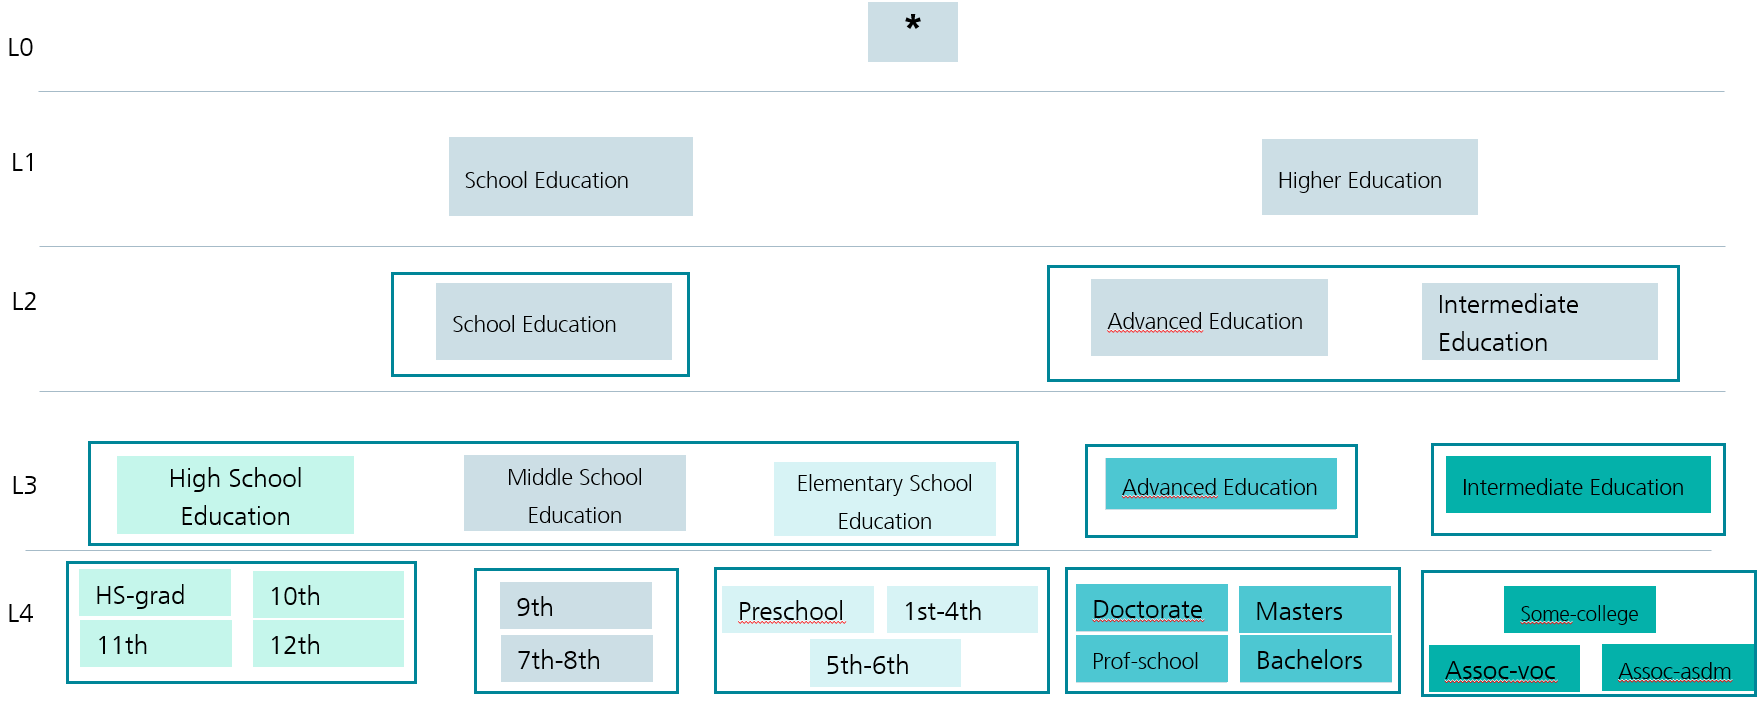

In [ ]:
education_type_mapping = {
    'L1_education': {
        "HS-grad": ["School Education"],
        "11th": ["School Education"],
        "12th": ["School Education"],
        "10th": ["School Education"],
        "9th": ["School Education"],
        "7th-8th": ["School Education"],
        "5th-6th": ["School Education"],
        "1st-4th": ["School Education"],
        "Preschool": ["School Education"],
        "Doctorate": ["Higher Education"],
        "Prof-school": ["Higher Education"],
        "Masters": ["Higher Education"],
        "Bachelors": ["Higher Education"],
        "Assoc-acdm": ["Higher Education"],
        "Assoc-voc": ["Higher Education"],
        "Some-college": ["Higher Education"]
    },
        'L2_education': {
        "HS-grad": ["School Education"],
        "11th": ["School Education"],
        "12th": ["School Education"],
        "10th": ["School Education"],
        "9th": ["School Education"],
        "7th-8th": ["School Education"],
        "5th-6th": ["School Education"],
        "1st-4th": ["School Education"],
        "Preschool": ["School Education"],
        "Doctorate": ["Advanced Education"],
        "Prof-school": ["Advanced Education"],
        "Masters": ["Advanced Education"],
        "Bachelors": ["Advanced Education"],
        "Assoc-acdm": ["Intermediate Education"],
        "Assoc-voc": ["Intermediate Education"],
        "Some-college": ["Intermediate Education"]
    },
        'L3_education': {
        "HS-grad": ["High School Education"],
        "11th": ["High School Education"],
        "12th": ["High School Education"],
        "10th": ["High School Education"],
        "9th": ["Middle/Elementary School Education"],
        "7th-8th": ["Middle/Elementary School Education"],
        "5th-6th": ["Middle/Elementary School Education"],
        "1st-4th": ["Middle/Elementary School Education"],
        "Preschool": ["Middle/Elementary School Education"],
        "Doctorate": ["Advanced Education"],
        "Prof-school": ["Advanced Education"],
        "Masters": ["Advanced Education"],
        "Bachelors": ["Advanced Education"],
        "Assoc-acdm": ["Intermediate Education"],
        "Assoc-voc": ["Intermediate Education"],
        "Some-college": ["Intermediate Education"]
    },
        'L4_education': {
        "HS-grad": ["High School Education"],
        "11th": ["High School Education"],
        "12th": ["High School Education"],
        "10th": ["High School Education"],
        "9th": ["Middle School Education"],
        "7th-8th": ["Middle School Education"],
        "5th-6th": ["Elementary School Education"],
        "1st-4th": ["Elementary School Education"],
        "Preschool": ["Elementary School Education"],
        "Doctorate": ["Advanced Education"],
        "Prof-school": ["Advanced Education"],
        "Masters": ["Advanced Education"],
        "Bachelors": ["Advanced Education"],
        "Assoc-acdm": ["Intermediate Education"],
        "Assoc-voc": ["Intermediate Education"],
        "Some-college": ["Intermediate Education"]
    }
}


for col, mapping in education_type_mapping.items():
    df[col] = df['education'].map({key: ' '.join(value) for key, value in mapping.items()})

### Occupation Generalization

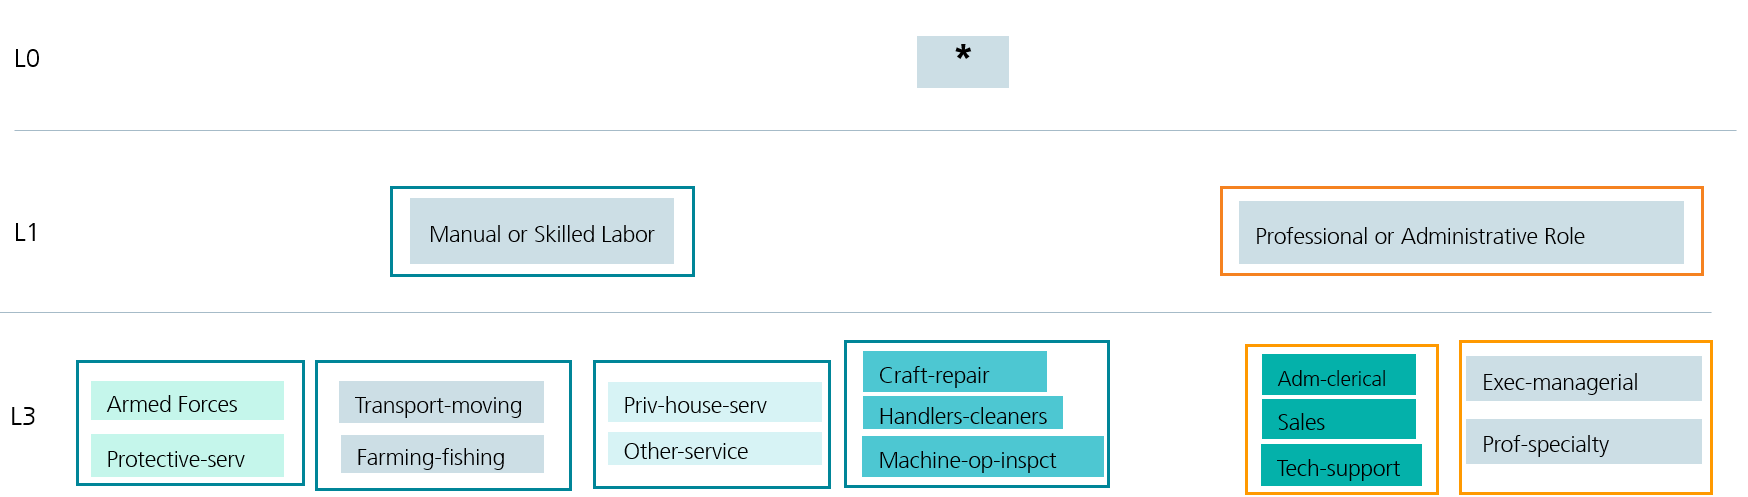

In [ ]:
occupation_type_mapping = {
    'L1_occupation': {
        "Exec-managerial": ["Professional or Administrative Role"],
        "Prof-specialty": ["Professional or Administrative Role"],
        "Tech-support": ["Professional or Administrative Role"],
        "Sales": ["Professional or Administrative Role"],
        "Adm-clerical": ["Professional or Administrative Role"],
        "Craft-repair": ["Manual and Skilled Labor"],
        "Handlers-cleaners": ["Professional or Administrative Role"],
        "Machine-op-inspct": ["Manual and Skilled Labor"],
        "Other-service": ["Manual and Skilled Labor"],
        "Priv-house-serv": ["Manual and Skilled Labor"],
        "Farming-fishing": ["Manual and Skilled Labor"],
        "Transport-moving": ["Manual and Skilled Labor"],
        "Protective-serv": ["Manual and Skilled Labor"],
        "Armed-Forces": ["Manual and Skilled Labor"],

    },
        'L2_occupation': {
        "Exec-managerial": ["Management or Professional Role"],
        "Prof-specialty": ["Management or Professional Role"],
        "Tech-support": ["Sales and Customer Service"],
        "Sales": ["Sales and Customer Service"],
        "Adm-clerical": ["Sales and Customer Service"],
        "Craft-repair": ["Skilled Labor and Craftsmanship"],
        "Handlers-cleaners": ["Skilled Labor and Craftsmanship"],
        "Machine-op-inspct": ["Skilled Labor and Craftsmanship"],
        "Other-service": ["Service and Household Roles"],
        "Priv-house-serv": ["Service and Household Roles"],
        "Farming-fishing": ["Agriculture or Transportation"],
        "Transport-moving": ["Agriculture or Transportation"],
        "Protective-serv": ["Security Services"],
        "Armed-Forces": ["Security Services"],
    }

}


for col, mapping in occupation_type_mapping.items():
    df[col] = df['occupation'].map({key: ' '.join(value) for key, value in mapping.items()})

### Marital status Generalization

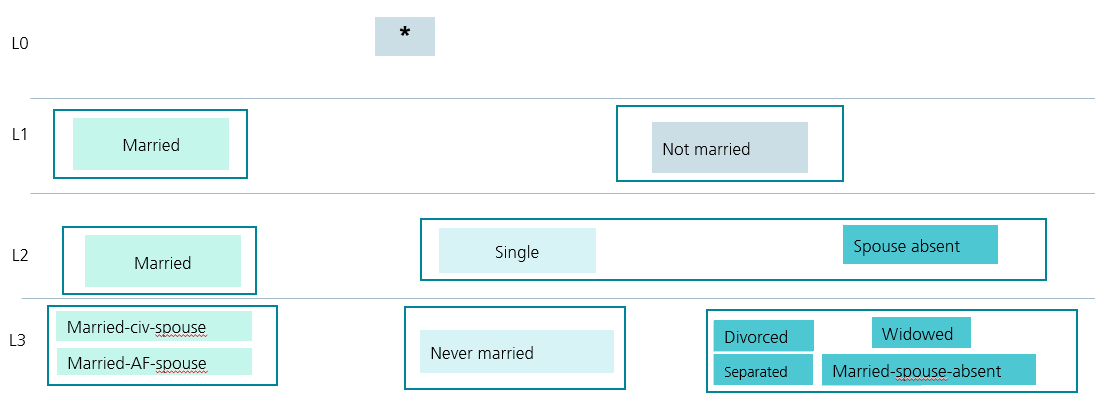

In [ ]:
marital_status_mapping = {
    'L1_marital_status': {
        "Married-civ-spouse": ["Married"],
        "Married-spouse-absent": ["Married"],
        "Married-AF-spouse": ["Married"],
        "Widowed": ["Not married"],
        "Separated": ["Not married"],
        "Divorced": ["Not married"],
        "Never-married": ["Not married"],
    },
      'L2_marital_status': {
        "Married-civ-spouse": ["Married"],
        "Married-spouse-absent": ["Spouse absent"],
        "Married-AF-spouse": ["Married"],
        "Widowed": ["Spouse absent"],
        "Separated": ["Spouse absent"],
        "Divorced": ["Spouse absent"],
        "Never-married": ["Single"],
    }

}


for col, mapping in marital_status_mapping.items():
    df[col] = df['marital-status'].map({key: ' '.join(value) for key, value in mapping.items()})

#rename marital statuis column to Level 3 marital status type also rethink the grouping if we get an insufficient classification accuracy

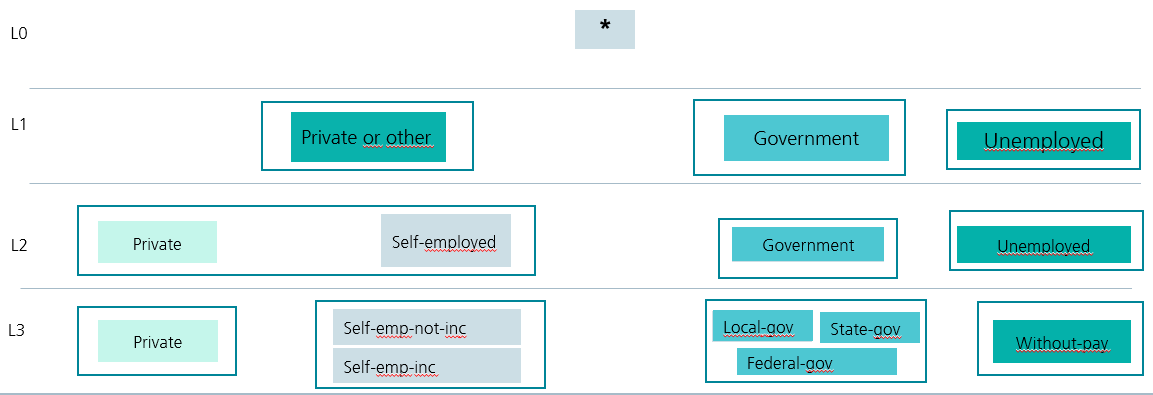

In [ ]:
workclass_mapping = {
    'L1_workclass': {
        "Private": ["Private or other"],
        "Self-emp-not-inc": ["Private or other"],
        "Self-emp-inc": ["Private or other"],
        "Local-gov": ["Government"],
        "State-gov": ["Government"],
        "Federal-gov": ["Government"],
        "Without-pay": ["Unemployed"],
    },
    'L2_workclass': {
        "Private": ["Private"],
        "Self-emp-not-inc": ["Self-employed"],
        "Self-emp-inc": ["Self-employed"],
        "Local-gov": ["Government"],
        "State-gov": ["Government"],
        "Federal-gov": ["Government"],
        "Without-pay": ["Unemployed"],
    }

}


for col, mapping in workclass_mapping.items():
    df[col] = df['workclass'].map({key: ' '.join(value) for key, value in mapping.items()})

### Native Country Genaralization

In [ ]:
native_country_mapping = {
    'L1_native_country': {
        "United-States": ["North America"],
        "South": ["North America"],
        "Canada": ["North America"],
        "Mexico": ["North America"],
        "Puerto-Rico": ["North America"],
        "El-Salvador": ["North America"],
        "Cuba": ["North America"],
        "Jamaica": ["North America"],
        "Dominican-Republic": ["North America"],
        "Guatemala": ["North America"],
        "Haiti": ["North America"],
        "Nicaragua": ["North America"],
        "Honduras": ["North America"],
        "Trinadad&Tobago": ["North America"],
        "Outlying-US(Guam-USVI-etc)": ["North America"],
        "Peru": ["South America"],
        "Columbia": ["South America"],
        "Ecuador": ["South America"],
        "Philippines": ["Asia"],
        "India": ["Asia"],
        "China": ["Asia"],
        "Hong": ["Asia"],
        "Japan": ["Asia"],
        "Vietnam": ["Asia"],
        "Taiwan": ["Asia"],
        "Cambodia": ["Asia"],
        "Thailand": ["Asia"],
        "Laos": ["Asia"],
        "Iran": ["Asia"],
        "Germany": ["Europe"],
        "England": ["Europe"],
        "Italy": ["Europe"],
        "Poland": ["Europe"],
        "Portugal": ["Europe"],
        "Greece": ["Europe"],
        "France": ["Europe"],
        "Ireland": ["Europe"],
        "Yugoslavia": ["Europe"],
        "Scotland": ["Europe"],
        "Holand-Netherlands": ["Europe"],
        "Hungary": ["Europe"],


},
    'L2_native_country': {
        "United-States": ["North America"],
        "South": ["North America"],
        "Canada": ["North America"],
        "Mexico": ["North America"],
        "Puerto-Rico": ["Central America and the Caribbean"],
        "El-Salvador": ["Central America and the Caribbean"],
        "Cuba": ["Central America and the Caribbean"],
        "Jamaica": ["Central America and the Caribbean"],
        "Dominican-Republic": ["Central America and the Caribbean"],
        "Guatemala": ["Central America and the Caribbean"],
        "Haiti": ["Central America and the Caribbean"],
        "Nicaragua": ["Central America and the Caribbean"],
        "Honduras": ["Central America and the Caribbean"],
        "Trinadad & Tobago": ["Central America and the Caribbean"],
        "Outlying-US(Guam-USVI-etc)": ["Central America and the Caribbean"],
        "Peru": ["South America"],
        "Columbia": ["South America"],
        "Ecuador": ["South America"],
        "Philippines": ["East Asia"],
        "India": ["Southern Asia"],
        "China": ["East Asia"],
        "Hong": ["East Asia"],
        "Japan": ["East Asia"],
        "Vietnam": ["Southeast Asia"],
        "Taiwan": ["East Asia"],
        "Cambodia": ["Southeast Asia"],
        "Thailand": ["Southeast Asia"],
        "Laos": ["Southeast Asia"],
        "Iran": ["Southern Asia"],
        "Germany": ["Western Europe"],
        "England": ["Northern Europe"],
        "Italy": ["Southern Europe"],
        "Poland": ["Eastern Europe"],
        "Portugal": ["Southern Europe"],
        "Greece": ["Southern Europe"],
        "France": ["Western Europe"],
        "Ireland": ["Western Europe"],
        "Yugoslavia": ["Eastern Europe"],
        "Scotland": ["Northern Europe"],
        "Holand-Netherlands": ["Western Europe"],
        "Hungary": ["Eastern Europe"],

    }

}


for col, mapping in native_country_mapping.items():
    df[col] = df['native-country'].map({key: ' '.join(value) for key, value in mapping.items()})

### Race Generalization

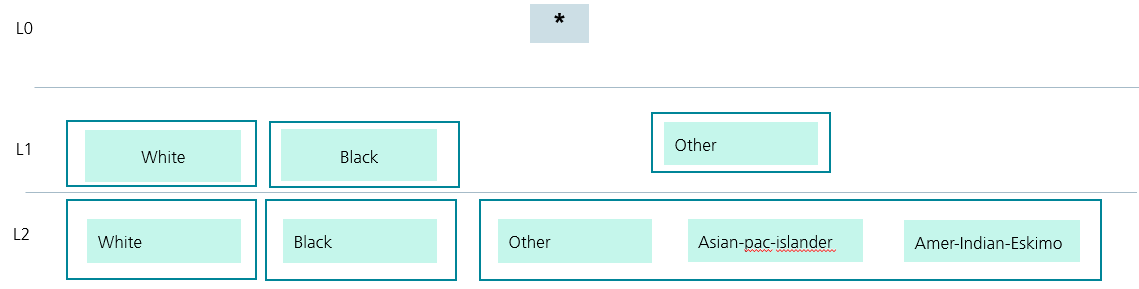

In [ ]:
race_mapping = {
    'L1_race': {
        "White": ["White"],
        "Black": ["Black"],
        "Other": ["Other"],
        "Asian-Pac-Islander": ["Other"],
        "Amer-Indian-Eskimo": ["Other"],
    }

}


for col, mapping in race_mapping.items():
    df[col] = df['race'].map({key: ' '.join(value) for key, value in mapping.items()})

## Rename columns and save dataframe as csv

In [ ]:
#df.rename(columns={'race': 'L2_race', 'marital-status': 'L3_marital_status', 'education': 'L5_education', 'native-country': 'L3_native_country', 'workclass': 'L3_workclass', 'occupation': 'L3_occupation', 'age': 'L7_age'}, inplace=True)


In [ ]:
# Save the pre-processed dataset on drive
#df.to_csv('/content/drive/MyDrive/Colab Notebooks/MIMIC III/adult_v1_gen.csv', index=False)

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Archived Code Snippets

In [ ]:
'''
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report

#selected_columns = best_solution

# Additional columns to include in the feature set
# maybe add oasis and glucose later

features = ['sex', 'salary-class', 'age', 'education', 'occupation', 'marital_status', 'workclass', 'native_country', 'race']



featurez_matrix = df[features]


# Prepare the feature matrix (X) and target variable (y)
X = featurez_matrix.drop('salary-class', axis=1)
y = featurez_matrix['salary-class']


# Convert categorical features to strings
categorical_features_indices = X.select_dtypes(include=['object']).columns
#X[categorical_features_indices] = X[categorical_features_indices].astype(str)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



# Initialize the CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=200, depth=8, learning_rate=0.1, loss_function='Logloss', cat_features=list(categorical_features_indices))

# Train the model on the training data
catboost_model.fit(X_train, y_train, cat_features=list(categorical_features_indices))  # Convert to list here

# Predict on the testing data
y_pred = catboost_model.predict(X_test)
# Convert the predicted labels to string type
y_pred = y_pred.astype(str)


# Evaluate the model's performance
classification_metrics = classification_report(y_test, y_pred)
print(classification_metrics)

# Calculate AUC-ROC score

auc_roc = roc_auc_score(y_test.astype(int), y_pred.astype(int))
print("AUC-ROC Score:", auc_roc)

'''

'\nimport pandas as pd\nfrom sklearn.model_selection import train_test_split\nfrom catboost import CatBoostClassifier\nfrom sklearn.impute import SimpleImputer\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.metrics import accuracy_score, classification_report\n\n#selected_columns = best_solution\n\n# Additional columns to include in the feature set\n# maybe add oasis and glucose later\n\nfeatures = [\'sex\', \'salary-class\', \'age\', \'education\', \'occupation\', \'marital_status\', \'workclass\', \'native_country\', \'race\']\n\n\n\nfeaturez_matrix = df[features]\n\n\n# Prepare the feature matrix (X) and target variable (y)\nX = featurez_matrix.drop(\'salary-class\', axis=1)\ny = featurez_matrix[\'salary-class\']\n\n\n# Convert categorical features to strings\ncategorical_features_indices = X.select_dtypes(include=[\'object\']).columns\n#X[categorical_features_indices] = X[categorical_features_indices].astype(str)\n\n# Split the data into training and testing sets\nX_train,

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 30162 non-null  object 
 1   sex                30162 non-null  object 
 2   age                30162 non-null  float64
 3   race               30162 non-null  object 
 4   marital-status     30162 non-null  object 
 5   education          30162 non-null  object 
 6   native-country     30162 non-null  object 
 7   workclass          30162 non-null  object 
 8   occupation         30162 non-null  object 
 9   salary-class       30162 non-null  object 
 10  L1_age             30162 non-null  object 
 11  L2_age             30162 non-null  object 
 12  L3_age             30162 non-null  object 
 13  L4_age             30162 non-null  object 
 14  L5_age             30162 non-null  object 
 15  L6_age             30162 non-null  object 
 16  L1_education       301

In [ ]:
'''
import pandas as pd
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report

selected_columns = best_solution


feature_matrix = df[selected_columns]




#########################

##ALTERNATIVE K-ANONYM:
#df_test = df.copy()

# Group the dataset by the quasi-identifiers and suppress the groups with less than k rows
grouped = feature_matrix.groupby(selected_columns)

suppressed_indices = []
for group_name, group in grouped:
    if len(group) < k:
        suppressed_indices.extend(group.index)
       #print(f"Group: {group_name}")
        #print(f"Number of Rows: {len(group)}")
        #print(f"Columns:")
        #print(group)
        #print("--------------------")


feature_matrix = feature_matrix.drop(suppressed_indices)
#df.info()

# Restore the original index
#df_index = df_test.index
#df_test = df_test.reset_index(drop=True)

#counter = 0

#for index in suppressed_indices:
#    counter = counter + 1
    #print(df.loc[index])
    #print("------------")

print("Suppressed Indices:", suppressed_indices)


########END#############



# Prepare the feature matrix (X) and target variable (y)
X = df[selected_columns]
y = df['salary-class']


# Convert categorical features to strings
categorical_features_indices = X.select_dtypes(include=['object']).columns
#X[categorical_features_indices] = X[categorical_features_indices].astype(str)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)



# Initialize the CatBoostClassifier
catboost_model = CatBoostClassifier(iterations=500, depth=10, learning_rate=0.1, loss_function='Logloss', cat_features=list(categorical_features_indices))

# Train the model on the training data
catboost_model.fit(X_train, y_train, cat_features=list(categorical_features_indices))  # Convert to list here

# Predict on the testing data
y_pred = catboost_model.predict(X_test)
# Convert the predicted labels to string type
y_pred = y_pred.astype(str)


# Evaluate the model's performance
classification_metrics = classification_report(y_test, y_pred)
print(classification_metrics)

# Calculate AUC-ROC score
#auc_roc = roc_auc_score(y_test, y_pred)
#print("AUC-ROC Score:", auc_roc)
#print('sum of supressed records:', len(suppressed_indices))
# Calculate AUC-ROC score
auc_roc = roc_auc_score(y_test.astype(int), y_pred.astype(int))
print("AUC-ROC Score:", auc_roc)
print('sum of suppressed records:', len(suppressed_indices))

'''

'\nimport pandas as pd\nfrom sklearn.model_selection import train_test_split\nfrom catboost import CatBoostClassifier\nfrom sklearn.impute import SimpleImputer\nfrom imblearn.over_sampling import SMOTE\nfrom sklearn.metrics import accuracy_score, classification_report\n\nselected_columns = best_solution\n\n\nfeature_matrix = df[selected_columns]\n\n\n\n\n#########################\n\n##ALTERNATIVE K-ANONYM:\n#df_test = df.copy()\n\n# Group the dataset by the quasi-identifiers and suppress the groups with less than k rows\ngrouped = feature_matrix.groupby(selected_columns)\n\nsuppressed_indices = []\nfor group_name, group in grouped:\n    if len(group) < k:\n        suppressed_indices.extend(group.index)\n       #print(f"Group: {group_name}")\n        #print(f"Number of Rows: {len(group)}")\n        #print(f"Columns:")\n        #print(group)\n        #print("--------------------")\n\n\nfeature_matrix = feature_matrix.drop(suppressed_indices)\n#df.info()\n\n# Restore the original index\n#